# ARIMA experimentation

Because the ARIMA model sucks ass for it's implementation, we'll try some different implementations

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime as dt

def plot_results(*args, **kwargs):
    fig, ax = plt.subplots(1,1)
    fig.set_figheight(6)
    fig.set_figwidth(6)

    test_axis = pd.date_range(test_start, test_end, freq="D")
    train_axis = pd.date_range(train_start, train_end, freq="D")
    ax.plot(train_axis, y_train)
    ax.plot(test_axis, y_test)
    ax.plot(test_axis, y_pred)

    ax.set(xlabel='Date', ylabel="Open", title=f'run:{seed}; ticker:{ticker}; score: {round(score, 3)}')
    ax.tick_params(labelrotation=45)
    ax.legend(["Train", "Test", "Prediction"])
    ax.grid()

In [6]:
from run import *
from sklearn import metrics

# Random state
seed = 0
random_state = np.random.RandomState(seed)

response_variables = ["open"]
all_response_variables = ["open", "high", "low", "close"]
period = 1
length_prediction = 7
train_test_ratio = 10
input_blacklist = [ 'daily_doses',
       'c1_policyvalue_actual', 'c2_policyvalue_actual',
       'c3_policyvalue_actual', 'c4_policyvalue_actual',
       'c5_policyvalue_actual', 'c6_policyvalue_actual',
       'c7_policyvalue_actual', 'c8_policyvalue_actual',
       'e1_policyvalue_actual', 'e2_policyvalue_actual',
       'e3_policyvalue_actual', 'e4_policyvalue_actual',
       'h1_policyvalue_actual', 'h2_policyvalue_actual',
       'h3_policyvalue_actual', 'h4_policyvalue_actual',
       'h5_policyvalue_actual', 'h6_policyvalue_actual',
       'h7_policyvalue_actual', 'h8_policyvalue_actual',
       'v1_policyvalue_actual', 'v2_policyvalue_actual',
       'v3_policyvalue_actual',  # 'stringency_actual',
       'volume',
       'is_original_stockdata', 'is_original_jhu', 'open_is_increase', 'open_is_decrease',
       'open_is_equal', 'close_is_increase', 'close_is_decrease',
       'close_is_equal', 'low_is_increase', 'low_is_decrease', 'low_is_equal',
       'high_is_increase', 'high_is_decrease', 'high_is_equal',
       'volume_is_increase', 'volume_is_decrease', 'volume_is_equal']
# models = load_models(random_state)

model_kwargs = {
    "random": True,
    "random_state": random_state,
    "stepwise": True, 
    "trace": 1, 
    "error_action": "ignore",
    "seasonal": False,  # because we use Fourier
    "suppress_warnings": True,
    "n_fits": 20,
    "max_p": 16, 
    "max_q": 16, 
    "max_P": 16, 
    "max_Q": 16,
}

def generate_prediction(n=25):
    results = []
    # Load main data
    main_df = load_data()
    for i in range(n):
        run_result = {}
        # Sample ticker
        df, ticker = sample_single_stock(main_df.copy(), random_state)
        non_zero = df[df[response_variables[0]] != 0]
        non_zero_start, non_zero_end = non_zero[response_variables[0]].index.min(), non_zero[response_variables[0]].index.max()
        print(f"sampling from '{ticker}' with date range '{non_zero_start}' and '{non_zero_end}'") 
        df = df.loc[non_zero_start:non_zero_end]
        # Sample time period
        train_start, train_end, test_start, test_end, val_start, val_end = sample_time_series(df, random_state, length_prediction, train_test_ratio, period)
        # Split X and y
        y_cols = response_variables
        blacklist = [_ for _ in all_response_variables if _ not in y_cols] + input_blacklist
        X_cols = get_expl_vars(df.columns, y_cols, blacklist = blacklist)
        X, y = df[X_cols].copy(), df[y_cols].copy()
        # Set date to ordinal for correct predictions
        X["date"] = X.index.get_level_values("date")
        X["date"] = X["date"].map(datetime.toordinal)
        # Preprocess data
        m = 7
        def log_transform(x):
            return np.log(x + 1)
        transform_pipeline =  Pipeline([
            ('minmax', MinMaxScaler((1,2))),
            ('log', FunctionTransformer(log_transform)),
            # ('minmax2', MinMaxScaler((1,2))),
            # ('normality_transform', PowerTransformer(method='box-cox')),   
            ('scaler', MinMaxScaler((-1,1))),
        ])
        X_index, X_columns = X.index, X.columns
        X = pd.DataFrame(transform_pipeline.fit_transform(X, y), columns=X_columns, index=X_index)

        # Split X and y in train and test
        X_train, y_train, X_test, y_test, _, _ = train_test_val_split(X, y, train_start, train_end, test_start, test_end, val_start, val_end)

        # Build pipeline and fit model
        model = arima.AutoARIMA(**model_kwargs)

        # y_train = y_train.values.ravel()
        # y_test = y_test.values.ravel()

        model_pipeline = pmdarima.pipeline.Pipeline([
            ("ppc", ppc.FourierFeaturizer(m=m)),
            ("arima", model)
        ])
        fit = model_pipeline.fit(X=X_train, y=y_train)
        y_pred = model_pipeline.predict(n_periods=m, X=X_test)
        # Score model with symmetrics mean
        score = metrics.mean_absolute_percentage_error(y_test, y_pred)
        run_result = {
            "train_start": train_start, 
            "train_end": train_end, 
            "test_start": test_start, 
            "test_end": test_end,
            "ticker": ticker,
            "X_cols": X_cols,
            "y_cols": y_cols,
            "X_test": X_test,
            "y_test": y_test,
            "y_pred": y_pred,
            "score": score,
            "seed": seed
        }
        results += [run_result]
    return results
    

# Model results
# results = generate_prediction(5)

In [7]:
import math
import matplotlib.pyplot as plt
from datetime import datetime as dt

main_df = load_data()

def sub_data(df, ticker, start, end):
    df = df.loc[start:end].reset_index()
    return df[df["ticker"] == ticker].set_index("date")

def parse_time(ts):
    return dt.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d %H:%M:%S')

def plot_results(results_df, n, figscale=3):
    cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n / cols))
    plt_dims = (rows, cols)
    fig, axs = plt.subplots(*plt_dims)
    fig.set_figheight(plt_dims[0] * figscale)
    fig.set_figwidth(plt_dims[1] * figscale)
    for c in range(cols):
        for r in range(rows):
            i = c + r * cols
            try:
                run = results_df.loc[i]
                train_start = run["train_start"]
                train_end = run["train_end"]
                test_start = run["test_start"]
                test_end = run["test_end"]
                ticker = run["ticker"]

                n = len(run["y_pred"])
                freq = "D"
                train_axis = pd.date_range(train_start, train_end, freq=freq)
                test_axis = pd.date_range(test_start, test_end, freq=freq)

                df = sub_data(main_df, ticker, train_start, test_end)

                axs[r,c].plot(train_axis, df.loc[train_start:train_end]["open"])
                axs[r,c].plot(test_axis, run["y_test"])
                axs[r,c].plot(test_axis, run["y_pred"])

                axs[r,c].set(xlabel='Date', ylabel=str(run["y_cols"][0]).capitalize(), title=f'run:{i}; ticker:{ticker}; score: {round(run["score"], 3)}')
                axs[r,c].tick_params(labelrotation=45)
                axs[r,c].legend(["Train", "Test", "Prediction"])
                axs[r,c].grid()
            except:
                pass

    fig.tight_layout()
    # tight_layout doesn't take these labels into account. We'll need 
    # to make some room. These numbers are are manually tweaked. 
    # You could automatically calculate them, but it's a pain.
    fig.subplots_adjust(left=0.15, top=0.95)
    
    plt.show()

In [8]:
%matplotlib inline

sampling from 'ASRNL.AS' with date range '2020-01-02 00:00:00' and '2021-08-20 00:00:00'
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=136.660, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=163.069, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=134.821, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=135.789, Time=0.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=135.188, Time=0.70 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=130.987, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=139.258, Time=0.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=133.408, Time=0.60 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=140.384, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 5.936 seconds
sampling from 'RAND.AS' with date range '2020-01-02 00:00:00' and '2021-08-20 00:00:00'
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0

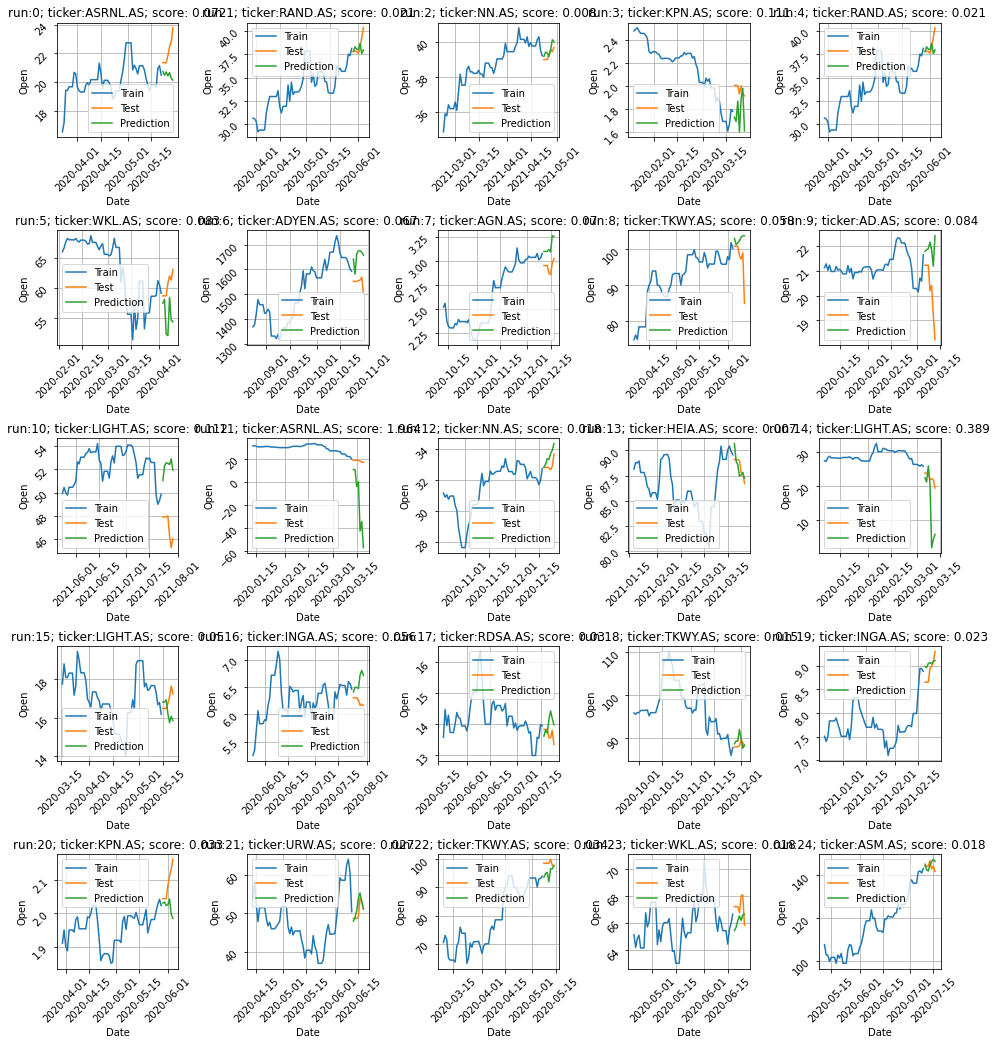

In [9]:
import pandas as pd

n=25
results = generate_prediction(n)
results_df = pd.DataFrame(results)

plot_results(results_df, n, figscale=3)

['24h_average_air_pressure_converted_to_sea_level', '24h_average_cloud_cover', '24h_average_relative_humidity', '24h_average_temperature', '24h_average_wind_speed', '24h_sum_of_precipitation', 'c1_policyvalue_actual', 'c2_policyvalue_actual', 'c3_policyvalue_actual', 'c4_policyvalue_actual', 'c5_policyvalue_actual', 'c6_policyvalue_actual', 'c7_policyvalue_actual', 'c8_policyvalue_actual', 'deceased', 'e1_policyvalue_actual', 'e2_policyvalue_actual', 'e3_policyvalue_actual', 'e4_policyvalue_actual', 'full_vaccinations', 'h1_policyvalue_actual', 'h2_policyvalue_actual', 'h3_policyvalue_actual', 'h4_policyvalue_actual', 'h5_policyvalue_actual', 'h6_policyvalue_actual', 'h7_policyvalue_actual', 'h8_policyvalue_actual', 'infected', 'is_original_jhu', 'partial_vaccinations', 'stringency_actual', 'total_doses', 'v1_policyvalue_actual', 'v2_policyvalue_actual', 'v3_policyvalue_actual']


,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,24h_average_temperature,24h_average_wind_speed,24h_sum_of_precipitation,c1_policyvalue_actual,c2_policyvalue_actual,c3_policyvalue_actual,c4_policyvalue_actual,...,h7_policyvalue_actual,h8_policyvalue_actual,infected,is_original_jhu,partial_vaccinations,stringency_actual,total_doses,v1_policyvalue_actual,v2_policyvalue_actual,v3_policyvalue_actual
date,,,,,,,,,,,,,,,,,,,,,
2020-10-12,10185.0,7.0,87.0,94,19.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6803,True,0,0.00,0,0.0,0.0,0.0
2020-10-13,10133.0,7.0,84.0,96,33.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7333,True,0,0.00,0,0.0,0.0,0.0
2020-10-14,10193.0,8.0,80.0,92,37.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,7251,True,0,62.04,0,0.0,0.0,0.0
2020-10-15,10218.0,7.0,74.0,94,32.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7777,True,0,0.00,0,0.0,0.0,0.0
2020-10-16,10233.0,7.0,81.0,83,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7951,True,0,0.00,0,0.0,0.0,0.0
2020-10-17,10211.0,5.0,89.0,71,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8105,True,0,0.00,0,0.0,0.0,0.0
2020-10-18,10216.0,7.0,90.0,88,15.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8148,True,0,0.00,0,0.0,0.0,0.0
2020-10-19,10189.0,8.0,85.0,94,20.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7986,True,0,0.00,0,0.0,0.0,0.0


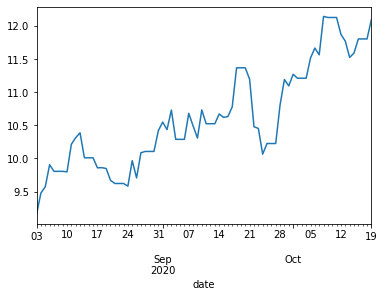

In [202]:
main_df = load_data()
run = results_df.loc[3]
y_cols = "open"
df = sub_data(main_df, run["ticker"], run["train_start"], run["test_end"])

df.open.plot()
# sample_time_series(df, random_state, length_prediction, train_test_ratio, period)
# train_start, train_end, test_start, test_end, val_start, val_end = 
print(run["X_cols"])
df.loc[run["test_start"]:run["test_end"]][run["X_cols"]]

In [180]:
df.loc[run["train_start"]:run["train_end"]][run["X_cols"]]

,24h_average_air_pressure_converted_to_sea_level,24h_average_cloud_cover,24h_average_relative_humidity,24h_average_temperature,24h_average_wind_speed,24h_sum_of_precipitation,daily_doses,deceased,full_vaccinations,infected,partial_vaccinations,total_doses
date,,,,,,,,,,,,
2021-02-22,10182.0,5.0,60.0,122,33.0,-1.0,0.0,33,218713,4179,795326,1014039
2021-02-23,10274.0,6.0,72.0,134,42.0,0.0,0.0,93,218713,3809,795326,1014039
2021-02-24,10270.0,5.0,69.0,137,42.0,0.0,0.0,63,218713,4368,795326,1014039
2021-02-25,10268.0,7.0,76.0,114,30.0,-1.0,0.0,29,218713,4986,795326,1014039
2021-02-26,10351.0,3.0,78.0,65,24.0,-1.0,0.0,71,218713,5089,795326,1014039
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,10044.0,5.0,50.0,108,40.0,0.0,89850.0,16,943197,8651,3880412,5265860
2021-04-29,10058.0,8.0,82.0,77,42.0,54.0,0.0,16,943197,7283,3880412,5265860
2021-04-30,10131.0,8.0,88.0,78,20.0,83.0,0.0,26,943197,7764,3880412,5265860
